In [38]:

cutoffs

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.3  , 0.4  , 0.5  , 0.6  , 0.7  , 0.8  , 0.9  ,
       1.   ])

In [1]:
seed = 0

import os
import sys

os.chdir('..')
utils_path = os.path.abspath("./utilities/")
sys.path.append(utils_path)

from load_data import load_fullECAI
from evaluation import *
from evaluation import _my_scorer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer
from sklearn.metrics import euclidean_distances
import joblib
from joblib import Parallel, delayed
import shap

from igraph import Graph
import igraph as ig

/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import powerlaw

In [3]:
def mean_degree(g):
    degree = g.degree_distribution()
    
    return degree.mean

def mean_dist_node_pairs(g):
    return


def exp_power_law_degrees(g):
    degrees = g.degree(g.vs)
    fitted = ig.statistics.power_law_fit(degrees)
    
    return fitted.alpha, fitted.xmin, fitted.p

def exp_power_law_alternative(g):
    degrees = g.degree(g.vs)
    results = powerlaw.Fit(data)
    
    return results.power_law.alpha, results.power_law.xmin

def exp_power_law_strengths(g):
    """
    H0: data was drawn from the fitted distribution

    """
    strengths = g.strength(g.vs, weights=1/(1+np.array(g.es['weight'])))
    fitted = ig.statistics.power_law_fit(strengths)
    
    return fitted.alpha, fitted.xmin, fitted.p


def cluster_coeff(g):
    return g.transitivity_undirected()


def random_cluster_coeff(g):
    n = g.vcount()
    degrees = g.degree(g.vs, loops=False)
    unique_degrees, degree_freqs = np.unique(degrees, return_counts=True)
    prop_degrees = degree_freqs/n
    moment_1 = np.dot(unique_degrees, prop_degrees)
    moment_2 = np.dot(unique_degrees**2, prop_degrees)
    
    return (1/n) * ((moment_2 - moment_1)**2) / (moment_1**3)


def assortativity_degree(g):
    assortativity = g.assortativity_degree(directed=False)
    return assortativity


def modularity(g, cats):
    # Checar si este es con distancias o fuerzas
    mod = g.modularity(cats.tolist(), weights=1/(1+np.array(g.es['weight'])))
    return mod

def summary(result, results_model, model_name):
    if result[1] == -1:
        # No calcular si la matriz no tiene conexiones
        return
    
    y_pred = results_model['y_pred']
    
    summary_stats = {}
    summary_stats['modelo'] = model_name
    summary_stats['corte'] = result[0]
    summary_stats['global_efficiency'] = result[1]
    summary_stats['aristas'] = result[2]
    summary_stats['mean_degree'] = mean_degree(result[3])
    
    # alpha, xmin, p = exp_power_law_degrees(result[3])
    # summary_stats['pow_degree_alpha'] = alpha
    # summary_stats['pow_degree_xmin'] = xmin
    # summary_stats['pow_degree_p'] = p
    
    # alpha, xmin, p = exp_power_law_strengths(result[3])
    # summary_stats['pow_str_alpha'] = alpha
    # summary_stats['pow_str_xmin'] = xmin
    # summary_stats['pow_str_p'] = p
    
    summary_stats['cluster_coeff'] = cluster_coeff(result[3])
    summary_stats['modularity'] = modularity(result[3], y_pred)
    summary_stats['Assort. degree'] = assortativity_degree(result[3])
    
    return summary_stats

def summary_handler(rgraph_pkl, model_name):
    """
    Parameters
    ----------
    rgraph_pkl: str
        reduced graph file name
    model_name: str
        Model name
    """
    complete_path = reduced_graphs_path + '/' + rgraph_pkl
    results_graph = joblib.load(complete_path)    
    summary_stats = summary(results_graph, results_model, model_name)
    return summary_stats

def stats_by_model(model):
    """
    
    Parameters
    ----------
    model: str
        Path of model.pkl
    """
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]
    results = joblib.load('{}/{}_reduced_graphs_efficiency.pkl'.format(model_folder, model_name))
    results_model = joblib.load(model)
    
    ## Stats per cutoff
    stats_tmp = Parallel(n_jobs=5)(delayed(summary)(r, results_model, model_name) for r in results)
    
    return stats_tmp

def plot_codo_eff_global(results, ax=None):
    if ax is None:
        ax = plt.gca()
        
    g_efficiencies = pd.Series(list(zip(*results))[1])
    g_efficiencies.plot(ax=ax)
    ax.set_xticks(range(10));
    ax.set_xticklabels(np.array(range(1,11))/10);

In [4]:
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [5]:
models_paths = ['./results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb.pkl', 
                './results/Basic1/models/RandomForestClassifier.pkl',
                './results/Basic1/models/LogisticRegression.pkl',
                './results/Basic1/models/LinearDiscriminantAnalysis.pkl'
               ]

## Global Efficiencies

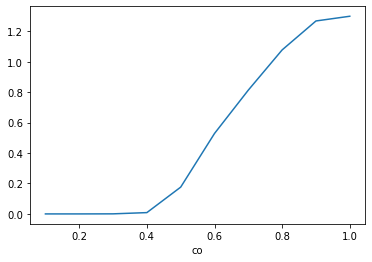

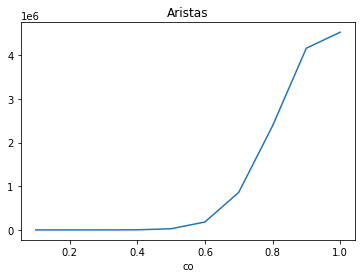

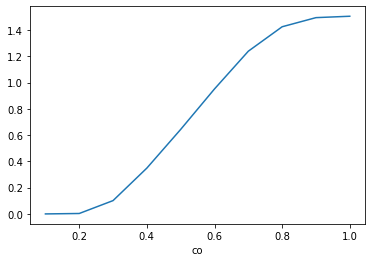

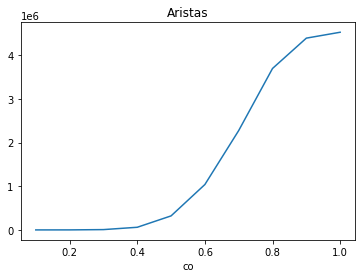

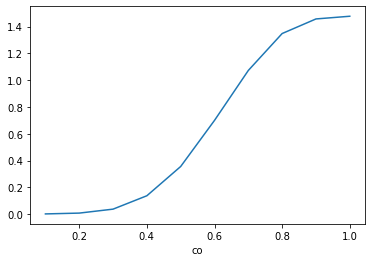

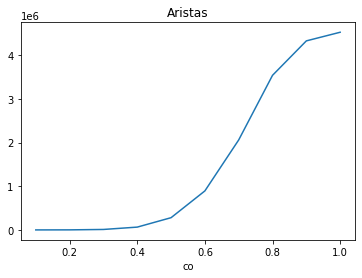

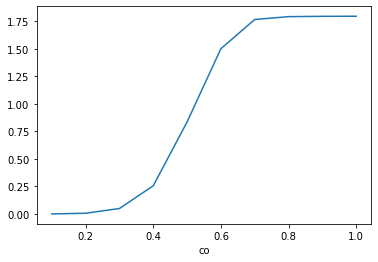

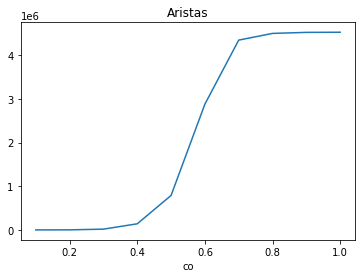

In [13]:
for model in models_paths:
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]

    reduced_graphs_path = '{}/reduced_graphs_log/{}'.format(model_folder, model_name)
    reduced_graphs_pkl = os.listdir(reduced_graphs_path)
    
    cos = []
    effs = []
    ars = []
    for red_graph in reduced_graphs_pkl:
        result = joblib.load(reduced_graphs_path + '/' + red_graph)
        co = result[0]
        eff = result[1]
        ar = result[2]
        
        cos.append(co)
        effs.append(eff)
        ars.append(ar)
        
    data = {'co':cos, 'eff':effs, 'ar':ars}
    
    df = pd.DataFrame(data)
    
    
    df.sort_values('co', inplace=True)
    df.set_index('co', inplace=True)
    df.eff.plot(title='')
    
    fig_name = '{}_codo_log.png'.format(model_name)
    fig_path = 'results/figures/graphs'.format(reduced_graphs_path, fig_name)
    plt.savefig(fig_path, bbox_inches='tight', dpi=300, transparent=True)
    plt.show()
    
    df.ar.plot(title='Aristas')
    plt.show()

## Main summary table

In [6]:
datas = []
for model in models_paths:
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]

    reduced_graphs_path = '{}/reduced_graphs_log/{}'.format(model_folder, model_name)
    reduced_graphs_pkl = os.listdir(reduced_graphs_path)
    results_model = joblib.load(model)
    
    data = Parallel(n_jobs=6)(delayed(summary_handler)(rgraph_pkl, model_name) for rgraph_pkl in reduced_graphs_pkl)
    data = list(filter(None, data)) # Some graphs are non-conected so summary returns None instead of a dict
    datas = datas + data

stats_df = pd.DataFrame(datas)

stats_df = (
    stats_df
    .set_index(['modelo', 'corte'])
    .sort_values(['modelo', 'corte'])
)

KeyboardInterrupt: 

In [33]:
stats_df['per_max_eff'] = stats_df.global_efficiency / stats_df.groupby('modelo').global_efficiency.transform(np.max)

In [28]:
stats_df

global_efficiency  aristas  mean_degree  \
modelo                     corte                                            
LogisticRegression         0.01          138.944096  1754660  1166.274510   
LinearDiscriminantAnalysis 0.01          217.169201  2710985  1801.917581   
                           0.04          218.685988  4408459  2930.182120   
LogisticRegression         0.04          143.514797  4118849  2737.686275   
RandomForestClassifier     0.04            0.008500      415     0.275839   
...                                             ...      ...          ...   
                           0.90            3.253556  4522132  3005.737454   
                           1.00            3.251265  4525536  3008.000000   
best_xgb                   1.00            2.216418  4525536  3008.000000   
LinearDiscriminantAnalysis 1.00          218.734038  4525536  3008.000000   
LogisticRegression         1.00          143.612782  4525536  3008.000000   

                                  cluster_coeff  modularity  Assort. degree  \
modelo                     corte                                              
LogisticRegression         0.01        0.904901    0.000019        0.319555   
LinearDiscriminantAnalysis 0.01        0.916625    0.000759        0.253280   
                           0.04        0.997684   -0.000027        0.035976   
LogisticRegression         0.04        0.990044    0.000101        0.152437   
RandomForestClassifier     0.04        0.377622    0.000000        0.467810   
...                                         ...         ...             ...   
                           0.90        0.999293    0.001748       -0.007189   
                           1.00        1.000000    0.001759             NaN   
best_xgb                   1.00        1.000000    0.008450             NaN   
LinearDiscriminantAnalysis 1.00        1.000000    0.000025             NaN   
LogisticRegression         1.00        1.000000    0.000004             NaN   

                                  per_max_eff  
modelo                     corte               
LogisticRegression         0.01      0.967491  
LinearDiscriminantAnalysis 0.01      0.992846  
                           0.04      0.999780  
LogisticRegression         0.04      0.999318  
RandomForestClassifier     0.04      0.002612  
...                                       ...  
                           0.90      0.999689  
                           1.00      0.998985  
best_xgb                   1.00      0.983434  
LinearDiscriminantAnalysis 1.00      1.000000  
LogisticRegression         1.00      1.000000  

[91 rows x 7 columns]

In [30]:
stats_df = pd.DataFrame(datas)
stats_df = stats_df.sort_values(['modelo', 'corte']).set_index(['modelo', 'corte'])

In [37]:
stats_df.loc['LogisticRegression']

,global_efficiency,aristas,mean_degree,cluster_coeff,modularity,Assort. degree,per_max_eff
corte,,,,,,,
0.01,138.944096,1754660,1166.274510,0.904901,0.000019,0.319555,0.967491
0.04,143.514797,4118849,2737.686275,0.990044,0.000101,0.152437,0.999318
0.07,143.586639,4428775,2943.685610,0.997828,0.000063,0.023044,0.999818
0.10,143.608659,4483039,2979.753406,0.999791,-0.000004,0.079744,0.999971
0.13,143.609818,4501312,2991.898970,0.999837,0.000004,0.041101,0.999979
0.16,143.611755,4504677,2994.135593,0.999957,0.000004,0.061819,0.999993
0.19,143.611989,4511951,2998.970422,0.999817,0.000004,0.007971,0.999994
0.22,143.612146,4516515,3002.003988,0.999986,0.000004,0.000132,0.999996
0.25,143.612223,4518188,3003.115985,0.999827,0.000004,-0.000808,0.999996


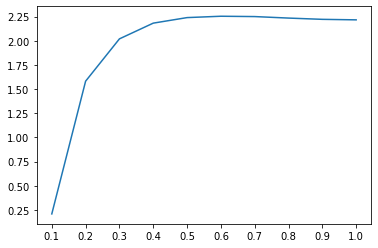

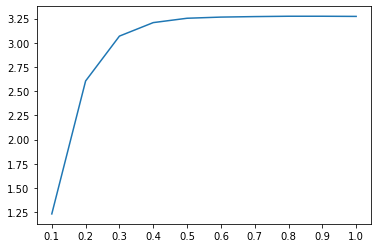

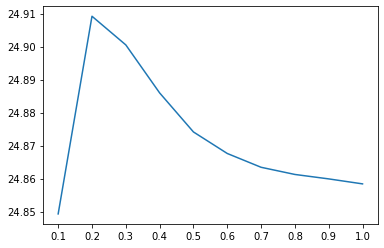

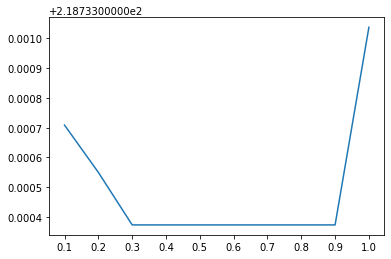

In [8]:
for model in models_paths:
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]
    results = joblib.load('{}/{}_reduced_graphs_efficiency.pkl'.format(model_folder, model_name))

    plot_codo_eff_global(results, ax=None)
    fig_name = '{}_codo.png'.format(model_name)
    fig_path = './results/figures/graphs/{}'.format(fig_name)
    plt.savefig(fig_path, bbox_inches='tight', dpi=300, transparent=True)
    plt.show()
    
    # Escalar ejes

In [20]:
stats_total = []
for model in models_paths:
    stats_tmp = stats_by_model(model)
    stats_total = stats_total + stats_tmp
stats_df = pd.DataFrame(stats_total)
stats_df['per_max_eff'] = stats_df.global_efficiency / stats_df.groupby('modelo').global_efficiency.transform(np.max)

stats_df.loc[stats_df.pow_degree_p > .1, 'degree_sig'] = ''
stats_df.loc[stats_df.pow_degree_p < .1, 'degree_sig'] = '*'
stats_df.loc[stats_df.pow_degree_p < .05, 'degree_sig'] = '**'
stats_df.loc[stats_df.pow_degree_p < .01, 'degree_sig'] = '***'

stats_df.loc[stats_df.pow_str_p > .1, 'str_sig'] = ''
stats_df.loc[stats_df.pow_str_p < .1, 'str_sig'] = '*'
stats_df.loc[stats_df.pow_str_p < .05, 'str_sig'] = '**'
stats_df.loc[stats_df.pow_str_p < .01, 'str_sig'] = '***'

In [21]:
# Optimal
stats_df[stats_df['per_max_eff'] > .80].groupby('modelo').first()

,corte,global_efficiency,aristas,mean_degree,pow_degree_alpha,pow_degree_xmin,pow_degree_p,pow_str_alpha,pow_str_xmin,pow_str_p,cluster_coeff,modularity,Assort. degree,per_max_eff,degree_sig,str_sig
modelo,,,,,,,,,,,,,,,,
LinearDiscriminantAnalysis,0.1,218.733709,4495830,2988.255234,3433.082018,2998.0,0.062053,7810.553682,2975.837119,0.010801,0.999675,0.000032,0.026077,0.999998,*,**
LogisticRegression,0.1,24.849282,2303025,1530.757727,391.758003,2251.0,0.986096,360.350586,2128.133390,0.840555,0.932081,0.000052,0.423752,0.997595,,
RandomForestClassifier,0.3,3.068783,1828590,1215.413759,44.945713,1977.0,0.259964,65.289675,1681.341876,0.754877,0.821960,0.001317,0.280315,0.937314,,
best_xgb,0.3,2.019724,729971,485.191758,11.293838,977.0,0.213521,11.346527,770.011319,0.127554,0.689643,0.049384,0.510320,0.896160,,


In [22]:
# Tabla general
# Solo alrededor del corte optimo
# Modelo, submodelo por corte
stats_df

,modelo,corte,global_efficiency,aristas,mean_degree,pow_degree_alpha,pow_degree_xmin,pow_degree_p,pow_str_alpha,pow_str_xmin,pow_str_p,cluster_coeff,modularity,Assort. degree,per_max_eff,degree_sig,str_sig
0,best_xgb,0.1,0.208811,8422,5.597873,2.132089,8.0,8.891367e-02,2.216093,11.024041,3.324355e-02,0.639503,0.065182,0.795471,0.092650,*,**
1,best_xgb,0.2,1.582012,170298,113.192423,7.769554,353.0,1.110526e-01,8.157067,314.951833,1.424846e-01,0.606946,0.051965,0.631632,0.701945,,
2,best_xgb,0.3,2.019724,729971,485.191758,11.293838,977.0,2.135207e-01,11.346527,770.011319,1.275544e-01,0.689643,0.049384,0.510320,0.896160,,
3,best_xgb,0.4,2.182409,1624212,1079.569292,96.796118,1928.0,9.922593e-01,151.717687,1497.965549,9.828253e-01,0.789802,0.047496,0.541257,0.968344,,
4,best_xgb,0.5,2.239732,2498458,1660.656697,16.257166,2124.0,3.040092e-01,19.061300,1578.485341,3.134966e-01,0.858718,0.044277,0.411350,0.993779,,
5,best_xgb,0.6,2.253753,3336720,2217.826520,10.215240,2289.0,1.853580e-11,14.910005,1769.467694,8.869780e-10,0.865016,0.035984,0.105467,1.000000,***,***
6,best_xgb,0.7,2.250345,4079939,2711.823862,2018.838683,3006.0,8.560743e-01,19.106712,1885.521785,8.022725e-23,0.936249,0.022229,-0.025013,0.998488,,***
7,best_xgb,0.8,2.234777,4403302,2926.754403,12.060715,2706.0,0.000000e+00,146.927060,2129.450991,9.813211e-02,0.979242,0.012340,-0.052614,0.991580,***,*
8,best_xgb,0.9,2.221705,4512639,2999.427717,2111.528771,3007.0,0.000000e+00,759.288282,2158.226163,9.999990e-01,0.997340,0.008711,-0.025845,0.985780,***,
9,best_xgb,1.0,2.216418,4525536,3008.000000,9659.355375,3008.0,1.000000e+00,717.024242,2156.142704,9.999987e-01,1.000000,0.008450,NaN,0.983434,,
